## Preliminary analysis of Amazon stock limit-order book data.


#### Date and timespan: 21-06-21 between 9:30 and 16:00.

In [153]:
# Importing
import numpy as np
import matplotlib.pyplot as plt
company = 'INTC'
path = 'results/inspect_data/'+company+'/'

In [177]:
# Reading data
# data = np.loadtxt('LOBSTER_Data/LOBSTER_SampleFile_'+company+'_2012-06-21_10/'+company+'_2012-06-21_34200000_57600000_orderbook_10.csv',delimiter=',')
message_data = np.loadtxt('LOBSTER_Data/LOBSTER_SampleFile_'+company+'_2012-06-21_10/'+company+'_2012-06-21_34200000_57600000_message_10.csv',delimiter=',')
data = np.loadtxt('LOB.csv', delimiter=',')

In [178]:
# Inspecting shape
data.shape

(201461, 40)

In [179]:
# Checking first row
data[0,:]

array([ 1.0000e+05,  1.0000e+04,  2.2357e+04,  1.0000e+02,  1.0000e+06,
        1.0000e+04, -1.0000e+05,  1.0000e+04,  1.0000e+10,  0.0000e+00,
       -1.0000e+06,  1.0000e+04,  1.0000e+10,  0.0000e+00, -1.0000e+10,
        0.0000e+00,  1.0000e+10,  0.0000e+00, -1.0000e+10,  0.0000e+00,
        1.0000e+10,  0.0000e+00, -1.0000e+10,  0.0000e+00,  1.0000e+10,
        0.0000e+00, -1.0000e+10,  0.0000e+00,  1.0000e+10,  0.0000e+00,
       -1.0000e+10,  0.0000e+00,  1.0000e+10,  0.0000e+00, -1.0000e+10,
        0.0000e+00,  1.0000e+10,  0.0000e+00, -1.0000e+10,  0.0000e+00])

#### Repeating info from the README file

    Columns:
	
 	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
	    ...

In [180]:
# Splitting data into levels (prices) and volumes
levels = (data[:,0::2]//100).astype(int)
volumes = (data[:,1::2]).astype(int)

# Inspecting arrays
print(levels.dtype)
print(levels.shape)

int64
(201461, 20)


In [181]:
# Splitting data into bid and ask
ask_levels = levels[:,0::2]
bid_levels = levels[:,1::2]

ask_volumes = volumes[:,0::2]
bid_volumes = volumes[:,1::2]

# Calculating mid prices
mid_prices = (ask_levels[:,0] + bid_levels[:,0])/2

print(mid_prices)


[611.5 223.5 223.5 ... 222.5 222.5 222.5]


In [182]:
# Define function to get normalized LOB at given index
# We should get 4 arrays
# bid ticks: [min_bid_tick - midprice, ..., -1]
# bid volumes: corresponding bid volumes
# ask ticks: [1, ..., max_ask_tick - midprice]
# ask volumes: corresponding ask volumes
def plot_lob(index):
    ask_level_row = list(ask_levels[index,:])
    bid_level_row = list(bid_levels[index,::-1])
    ask_volume_row = list(ask_volumes[index,:])
    bid_volume_row = list(bid_volumes[index,::-1])
    ask_level_list = []
    bid_level_list = []
    ask_volume_list = []
    bid_volume_list = []
    # Create lists with ask levels, ask volumes, bid levels and bid volumes
    for i,level in enumerate(ask_level_row):
        if int(level)!=9999999999:
            ask_level_list.append(int(level))
            ask_volume_list.append(ask_volume_row[i])
    for i,level in enumerate(bid_level_row):
        if int(level)!=-9999999999:
            bid_level_list.append(int(level))
            bid_volume_list.append(bid_volume_row[i])
    # Calculate mid price
    mid_price = (ask_level_list[0]+bid_level_list[-1])/2
    # Calculate min and max ticks for each side
    min_bid_tick = bid_level_list[0]
    max_bid_tick = int(np.floor(mid_price))
    max_ask_tick = ask_level_list[-1]
    min_ask_tick = int(np.ceil(mid_price))
    # Compile arrays of ticks for each side
    bid_ticks = list(range(min_bid_tick, max_bid_tick+1))
    bid_vols = []
    ask_ticks = list(range(min_ask_tick, max_ask_tick+1))
    ask_vols = []
    # Compile distionaries with price: volume for each side
    ask_dict = dict(zip(ask_level_list, ask_volume_list))
    bid_dict = dict(zip(bid_level_list, bid_volume_list))
    # Create lists for each tick
    for bid_tick in bid_ticks:
        bid_vols.append(bid_dict.get(bid_tick,0.))
    for ask_tick in ask_ticks:
        ask_vols.append(ask_dict.get(ask_tick,0.))
    # Normalize ticks by midprice rounded down for bid and up for ask
    bid_ticks = [int(np.floor(tick - mid_price)) for tick in bid_ticks]
    ask_ticks = [int(np.ceil(tick - mid_price)) for tick in ask_ticks]
    return bid_ticks, bid_vols, ask_ticks, ask_vols
    

In [183]:
# Plotting LOB at 6 time indices
fig, axs = plt.subplots(3,2,figsize=(10, 7))
for i,index in enumerate(list(range(0,1001,200))):
    bid_ticks, bid_vols, ask_ticks, ask_vols = plot_lob(index)
    print(index, i)
    x = i//3
    y = i%3
    axs[y,x].bar(bid_ticks, bid_vols, label='Bid')
    axs[y,x].bar(ask_ticks, ask_vols, label='Ask')
    axs[y,x].set_xlim([-120,120])
    axs[y,x].set_ylim([0,500])
    axs[y,x].legend(loc='upper left')
axs[2,0].set_xlabel('ticks from midprice')
axs[2,1].set_xlabel('ticks from midprice')
axs[0,0].set_ylabel('volume')
axs[1,0].set_ylabel('volume')
axs[2,0].set_ylabel('volume')
fig.suptitle('Normalized LOB at different points in a day')
plt.tight_layout()
plt.savefig(path+'Normalized_LOB_at_different_points_in_a_day.png')
plt.show()

0 0


KeyboardInterrupt: 

In [161]:
# Define function which normalizes LOB at given index
# Output is an array of dimension [max_tick-min_tick+1] with given volume for each level
# By default min_tick and max_tick are -100 and 100 respectively
def normalize(index, min_tick=-100, max_tick=100):
    # Get LOB row 
    ask_level_row = ask_levels[index,:]
    bid_level_row = bid_levels[index,::-1]
    ask_volume_row = ask_volumes[index,:]
    bid_volume_row = bid_volumes[index,::-1]

    double_price = (ask_level_row[0]+bid_level_row[-1])
    # print(ask_level_row[0], bid_level_row[-1])
    mid_price = double_price/2
    # print(mid_price)
    bid_level_row = (np.floor(bid_level_row - mid_price)).astype(int)
    ask_level_row = (np.ceil(ask_level_row - mid_price)).astype(int)

    # Concatenating both sides
    row_levels = np.hstack((bid_level_row,ask_level_row))
    row_vols = np.hstack((bid_volume_row, ask_volume_row))

    volumes = []
    ar_index = 0
    # Iterating over ticks in tick range (-min_tick, max_tick)
    for tick in range(min_tick, max_tick+1):
        # While not end of list and current row level smaller than tick
        while ar_index<len(row_levels) and row_levels[ar_index]<tick:
            # Increment index in the list of levels
            ar_index+=1
        # If reached end of list append 0
        if ar_index == len(row_levels):
            volumes.append(0)
            continue
        # If current level equal to tick
        if row_levels[ar_index]==tick:
            # Append correct LOB volume and increment level list index
            volumes.append(row_vols[ar_index])
            ar_index+=1
            continue
        # If level is bigger than tick it means no volume at tick so append 0
        volumes.append(0)

    return volumes

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4063, 3300, 2800, 900, 700, 300, 661, 200, 100, 400, 0, 66, 1000, 373, 0, 100, 100, 0, 8589, 959, 2300, 2700, 2000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


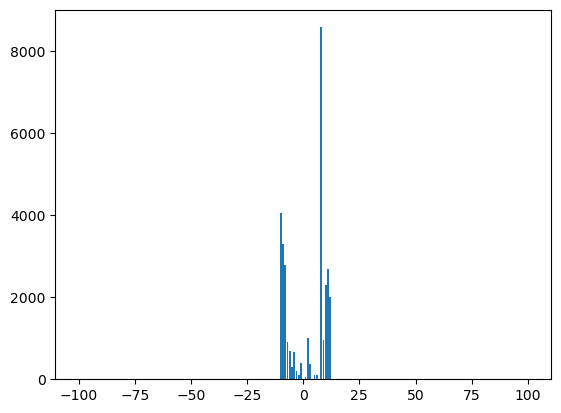

In [162]:
# Try the function
ticks = list(range(-100,101))
plt.bar(ticks, normalize(0))
print(normalize(0))
# max_price = normalize(0).index(max(normalize(0)))
# print(max_price)

In [163]:
# Normalize all data into one array of shape (levels.shape[0], max_ticks-min_ticks+1)
# May take around 20 seconds.
normalized_vols = []
for i in range(levels.shape[0]):
    normalized_vols.append(normalize(i))
normalized_vols = np.array(normalized_vols)

In [164]:
# Load time stamps from message data
time = (message_data[:,0]*10**9).astype(np.int64) # Time of message

# Defining helper function for printing time from seconds
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d" % (hour, minutes)


In [165]:
# Inspect shape
normalized_vols.shape

(624040, 201)

Plot average volume on LOB per 30 minute day windows. Corresponds to probability of LO per distance from midprice at any given moment.

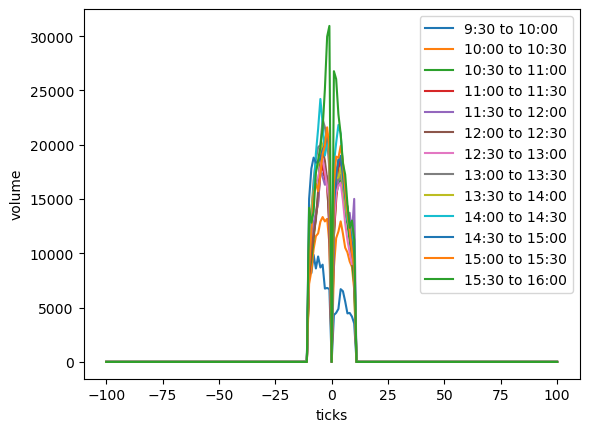

In [166]:
# Plot  half-hour-averaged LOBs
base_time = 34200000000000 # Starting time
time_increments = 30*60*10**9 # Time increments - 30 minutes
final_time = 57600000000000 # Final time

mean_volumes = []
tmp_vols = []
it=0
times = [base_time//10**9]
last_it=0
# Iterate over 30 minute windows
for i in range(base_time+time_increments,final_time+1, time_increments):
    # While LOB state corresponds to the 30 minute window
    while it<normalized_vols.shape[0] and time[it]<=i:
        # Increment LOB state array index
        it+=1
    # Calculate mean LOB for the window
    mean_vols = np.mean(normalized_vols[last_it:it,:], axis=0)
    # Reset starting index to current end index
    last_it = it
    # Append results
    mean_volumes.append(mean_vols)
    times.append(i//10**9)
# Plot
for i in range(len(times)-1):
    plt.plot(ticks, mean_volumes[i], label=f'{convert(times[i])} to {convert(times[i+1])}')
plt.xlabel('ticks')
plt.ylabel('volume')
plt.legend()
plt.savefig(path+'half_hour_averaged_LOBs.png')
plt.show()

Day-average of LOB state.

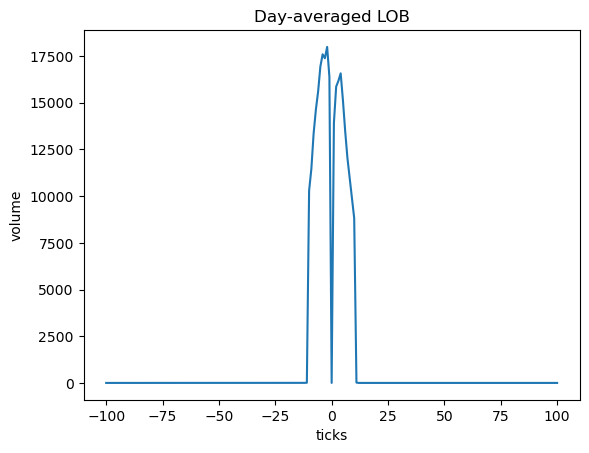

In [167]:
# Plot day-average LOB 
mean_vols = np.mean(normalized_vols, axis=0)
plt.plot(ticks, mean_vols)
plt.xlabel('ticks')
plt.ylabel('volume')
plt.title('Day-averaged LOB')
plt.savefig(path+'day_average_LOB.png')
plt.show()

Probability of Limit Order at position.

In [168]:
# If volume is bigger than 0 then there is LO at position - (probability=1)
# We create array of 1s and 0s for LOs at position for each LOB state in the array
LO_probs = np.minimum(normalized_vols, 1)
LO_probs[0,:]
# count = 0
# index_list = []
# for i in range(len(LO_probs[0,:])):
#     if LO_probs[0,:][i] > 0:
#         count+=1
#         index_list.append(i)
# index_list

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

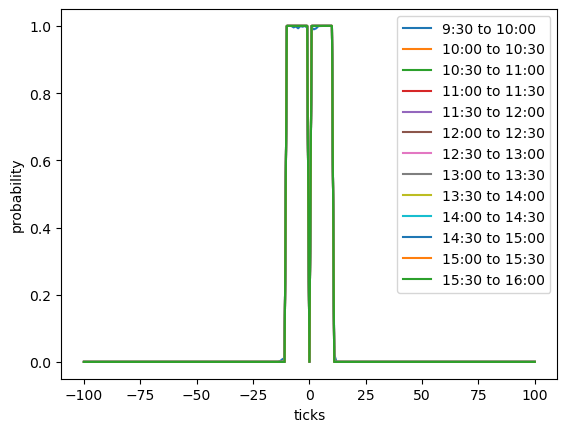

In [169]:
# Calculating probability per tick using 30 minute window
base_time = 34200000000000 # Starting time
time_increments = 30*60*10**9 # Time increments
final_time = 57600000000000 # Final time

probs = []
it=0
times = [base_time//10**9]
last_it=0
# Iterate over 30 minute windows
for i in range(base_time+time_increments,final_time+1, time_increments):
    # If LOB state fits within time window
    while it<LO_probs.shape[0] and time[it]<=i:
        # Increment index of LOB
        it+=1
    # Calculate average probability for the window
    prob = np.mean(LO_probs[last_it:it,:], axis=0)
    # Reset starting index to ending index
    last_it = it
    # Append results
    probs.append(prob)
    times.append(i//10**9)
# Plot
for i in range(len(times)-1):
    plt.plot(ticks, probs[i], label=f'{convert(times[i])} to {convert(times[i+1])}')
plt.xlabel('ticks')
plt.ylabel('probability')
plt.legend()
plt.savefig(path+'half_hour_probability_LOs.png')
plt.show()

Limit Order probability based on day average.

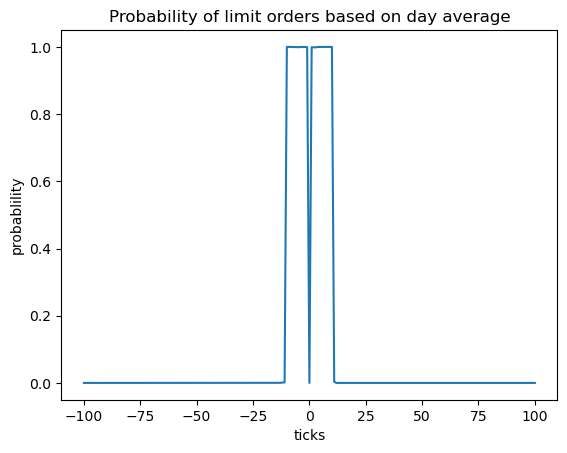

In [170]:
# Plot probablility based on day-average 
prob_vols = np.mean(LO_probs, axis=0)
plt.plot(ticks, prob_vols)
plt.xlabel('ticks')
plt.ylabel('probablility')
plt.title('Probability of limit orders based on day average')
plt.savefig(path+'day_average_probability_LOs.png')
plt.show()

Calculate the average price for Asking and Bidding. 

In [171]:
def row_price(index):
    ask_level_row = ask_levels[index,:]
    bid_level_row = bid_levels[index,::-1]
    ask_volume_row = ask_volumes[index,:]
    bid_volume_row = bid_volumes[index,::-1]
    total_ask = 0
    ask_count = 0
    total_bid = 0
    bid_count = 0
    for i in range(len(ask_level_row)):
        total_ask = total_ask + (ask_level_row[i]*ask_volume_row[i])
        total_bid = total_bid + (bid_level_row[i]*bid_volume_row[i])
        ask_count += ask_volume_row[i]
        bid_count += bid_volume_row[i]
    return np.true_divide(total_ask, ask_count), np.true_divide(total_bid, bid_count)

In [172]:
normalized_ask = []
normalized_bid = []
for i in range(levels.shape[0]):
    current_ask, current_bid = row_price(i)
    normalized_ask.append(current_ask)
    normalized_bid.append(current_bid)

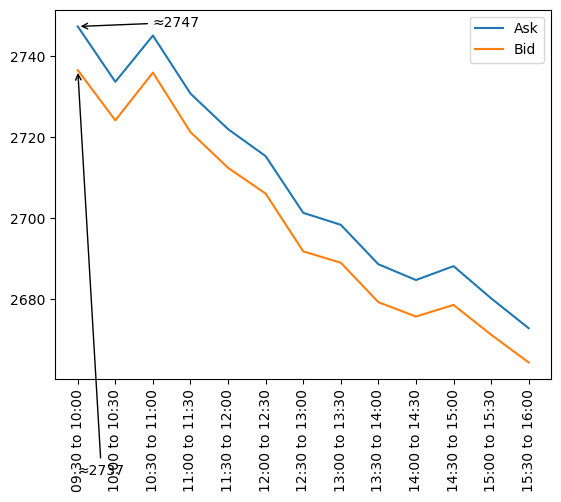

In [173]:
base_time = 34200000000000 # Starting time
time_increments = 30*60*10**9 # Time increments
final_time = 57600000000000 # Final time

mean_ask_price = []
mean_bid_price = []
times = []
it = 0
last_it = 0
# Iterating over 30 minute windows in the day
for i in range(base_time+time_increments,final_time+1, time_increments):
    times.append(i//10**9)
    # If LOB state fits within time window
    while it<LO_probs.shape[0] and time[it]<=i:
        # Increment index of LOB
        it+=1
    # Calculate average price for the window
    mean_ask = np.mean(normalized_ask[last_it:it])
    mean_bid = np.mean(normalized_bid[last_it:it])
    # Reset starting index to ending index
    last_it = it
    # Append results
    mean_bid_price.append(mean_bid)
    mean_ask_price.append(mean_ask)

def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if hour < 10:
        return "0%d:%02d" % (hour, minutes)
    return "%d:%02d" % (hour, minutes)
base_times = [34200]
base_times.extend(times)
hour_times = [convert(base_times[i]) +' to ' + convert(base_times[i+1]) for i in range(len(times))]

# Plot
plt.plot(list(range(0,13)), mean_ask_price, label='Ask')

plt.plot(list(range(0,13)), mean_bid_price, label='Bid')

ask_max = np.argmax(mean_ask_price)
show_ask_max = '≈'+str(round(mean_ask_price[ask_max]))
plt.annotate(show_ask_max,xy=(ask_max,mean_ask_price[ask_max]),xytext=(ask_max+2,mean_ask_price[ask_max]),xycoords='data',arrowprops=dict(arrowstyle="->"))

bid_max = np.argmax(mean_bid_price)
show_bid_max = '≈'+str(round(mean_bid_price[bid_max]))
plt.annotate(show_bid_max,xy=(bid_max,mean_bid_price[bid_max]),xytext=(bid_max,mean_bid_price[bid_max]-100),xycoords='data',arrowprops=dict(arrowstyle="->"))
plt.xticks(list(range(0,13)), hour_times, rotation=90)
plt.legend()
plt.savefig(path+'half_hour_average_price.png')


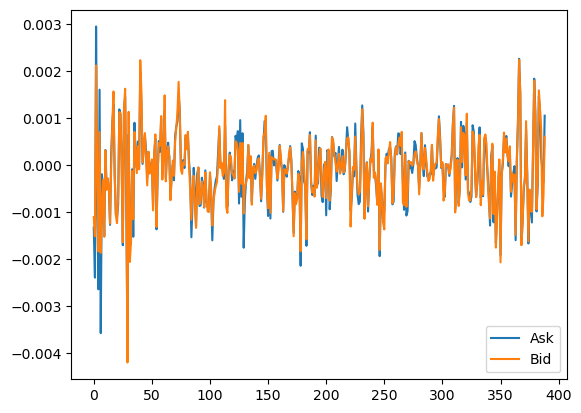

In [174]:
import math
base_time = 34200000000000 # Starting time
time_increments = 1*60*10**9 # Time increments
final_time = 57600000000000 # Final time
mean_ask_price = []
mean_bid_price = []
times = []
it = 0
last_it = 0
# Iterating over 1 minute windows in the day
for i in range(base_time+time_increments,final_time+1, time_increments):
    times.append(i//10**9)
    # If LOB state fits within time window
    while it<LO_probs.shape[0] and time[it]<=i:
        # Increment index of LOB
        it+=1
    # Calculate average price for the window
    mean_ask = np.mean(normalized_ask[last_it:it])
    mean_bid = np.mean(normalized_bid[last_it:it])
    # Reset starting index to ending index
    last_it = it
    # Append results
    mean_bid_price.append(mean_bid)
    mean_ask_price.append(mean_ask)
def log_price(price_list, time_t):
    return math.log(price_list[time_t], 2)
def log_returns(price_list, current_time, unit_time):
    log_difference = log_price(price_list, current_time+unit_time) - log_price(price_list, current_time)
    return log_difference
ask_returns = []
for i in range(len(mean_ask_price)-1):
    ask_returns.append(log_returns(mean_ask_price, i, 1))
# print(ask_returns)
bid_returns = []
for i in range(len(mean_bid_price)-1):
    bid_returns.append(log_returns(mean_bid_price, i, 1))
# print(bid_returns)
plt.plot(list(range(len(ask_returns))), ask_returns, label='Ask')
plt.plot(list(range(len(bid_returns))), bid_returns, label='Bid')
plt.legend()

Calculate the standard deviation for Asking and Bidding

In [175]:
def calculateSTD(index):
    ask_level_row = ask_levels[index,:]
    bid_level_row = bid_levels[index,::-1]
    ask_volume_row = ask_volumes[index,:]
    bid_volume_row = bid_volumes[index,::-1]
    complete_ask_level_row = []
    for i in range(len(ask_level_row)):
        for j in range(ask_volume_row[i]):
            complete_ask_level_row.append(ask_level_row[i])
    complete_bid_level_row = []
    for i in range(len(bid_level_row)):
        for j in range(bid_volume_row[i]):
            complete_bid_level_row.append(bid_level_row[i])
    return np.std(complete_ask_level_row), np.std(complete_bid_level_row)
calculateSTD(0)

(2.4285497423980384, 2.194096319144439)

In [176]:
STD_ask = []
STD_bid = []
for i in range(levels.shape[0]):
    current_ask, current_bid = calculateSTD(i)
    STD_ask.append(current_ask)
    STD_bid.append(current_bid)

KeyboardInterrupt: 

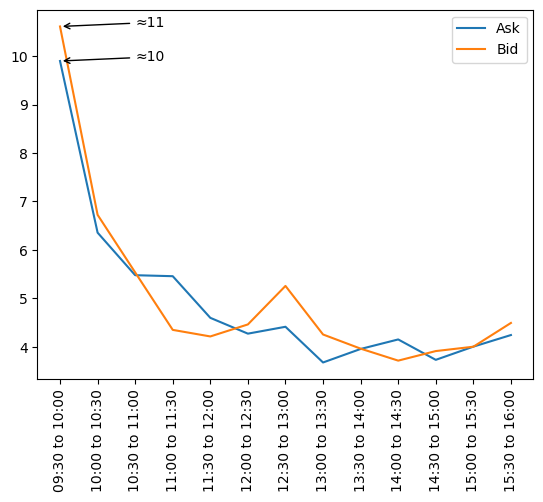

In [ ]:
base_time = 34200000000000 # Starting time
time_increments = 30*60*10**9 # Time increments
final_time = 57600000000000 # Final time

STD_ask_price = []
STD_bid_price = []
times = []
it = 0
last_it = 0
# Iterating over 30 minute windows in the day
for i in range(base_time+time_increments,final_time+1, time_increments):
    times.append(i//10**9)
    # If LOB state fits within time window
    while it<LO_probs.shape[0] and time[it]<=i:
        # Increment index of LOB
        it+=1
    # Calculate average standar deviation price for the window
    current_ask = np.mean(STD_ask[last_it:it])
    current_bid = np.mean(STD_bid[last_it:it])
    # Reset starting index to ending index
    last_it = it
    # Append results
    STD_bid_price.append(current_bid)
    STD_ask_price.append(current_ask)

base_times = [34200]
base_times.extend(times)
hour_times = [convert(base_times[i]) +' to ' + convert(base_times[i+1]) for i in range(len(times))]

# Plot
plt.plot(list(range(0,13)), STD_ask_price, label='Ask')

plt.plot(list(range(0,13)), STD_bid_price, label='Bid')

ask_max = np.argmax(STD_ask_price)
show_ask_max = '≈'+str(round(STD_ask_price[ask_max]))
plt.annotate(show_ask_max,xy=(ask_max,STD_ask_price[ask_max]),xytext=(ask_max+2,STD_ask_price[ask_max]),xycoords='data',arrowprops=dict(arrowstyle="->"))

bid_max = np.argmax(STD_bid_price)
show_bid_max = '≈'+str(round(STD_bid_price[bid_max]))
plt.annotate(show_bid_max,xy=(bid_max,STD_bid_price[bid_max]),xytext=(bid_max+2,STD_bid_price[bid_max]),xycoords='data',arrowprops=dict(arrowstyle="->"))
plt.xticks(list(range(0,13)), hour_times, rotation=90)
plt.legend()
plt.savefig(path+'half_hour_standard_deviation_price.png')